### [kdegrave.github.io](https://kdegrave.github.io/)

### Introduction

Healthgrades.com is a website where patients can go to research and compare thousands of healthcare providers in order to make the most informed decisions possible when seeking medical care. On the site, patients are able to leave text reviews detailing their experience in working with their provider. On the whole, reviews are generally quite positive in tone (about 70% of total) with patients enjoying their interaction and experience with the provider. There is, however, a large portion of reviews that are negative (about 30% of total). In some cases patients submit reviews that violate our site policy and must be flagged for removal. These reviews often contain coarse, inappropriate language that would be offensive to other users.

When I began working at Murcury Healthcare (formerly Healthgrades), a commercial sentiment model called Alchemy, part of the IMB Watson suite of tools, was already in place to identify negative-sentiment reviews submitted to the website. Once identified, these reviews were sent off to a human for further analysis. If they passed this inspection they were subsequently published to the site, otherwise they were rejected and permanently removed. Alchemy worked well initially, but we eventually ran into a couple of problems. The first was that Alchemy was expensive, costing the company tens of thousands of dollars in subscriptions fees every year. The second was that because so many reviews were being published to the website (over 300,000 or so every year), we needed the model to be as accurate as possible in identifying text that should be rejected while not bogging down analysts with too many false positives.

As an alternative to Alchemy, Healthgrades also considered another commercial model called Indico. Indico promised better overall performance than Alchemy, but was still costly in that it too required a yearly subscription fee. In order to get the best of both worlds - low cost and good performance - we decided to try building our own in-house model. This notebook details the work that went into building our model.

Let's get started by importing some libraries we'll need for the analysis.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from joblib import load, dump
import seaborn as sns

from matplotlib.pyplot import *
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

The functions below are used to clean the input review text. We'll remove special characters and extra white space, then replace and standardize common abbreviations.

In [3]:
def process_text(text):
    result = text.lower().strip()
    result = re.sub(r'\n', ' ', result)
    result = re.sub(r'\r', ' ', result)
    result = re.sub(r'[^\x00-\x7F]+', ' ', result)
    result = re.sub('[\W]+', ' ', result)
    result = re.sub(r' +', ' ', result).strip()
    return result

def replace_abbreviations(text):
    result = text.lower().strip()
    result = re.sub(r'\bpm\b', ' ', result)
    result = re.sub(r'\byrs\b', ' years ', result)
    result = re.sub(r'\bhr\b', ' hours ', result)
    result = re.sub(r'\bhrs\b', ' hours ', result)
    result = re.sub(r'\bmin\b', ' minutes ', result)
    result = re.sub(r'\bmins', ' minutes ', result)
    result = re.sub(r'\bdr\b', ' doctor ', result)
    result = re.sub(r'\bdoc\b', ' doctor ', result)
    result = re.sub(r'\bapt\b', ' appointment ', result)
    result = re.sub(r'\bappt\b', ' appointment ', result)
    result = re.sub(r' +', ' ', result).strip()
    return result

Let's load in the review data. 

### Read in the provider_reviews

In [4]:
provider_reviews = pd.read_csv('./data/provider_reviews.csv', encoding='ISO-8859-1')

In [5]:
provider_reviews.rename(columns={'review-text-cleaned': 'review_text'}, inplace=True)

provider_reviews = provider_reviews[provider_reviews['review_text'] != ''].reset_index(drop=True)

provider_reviews['rating'] = provider_reviews['rating'].replace({1: 0, -1: 1})

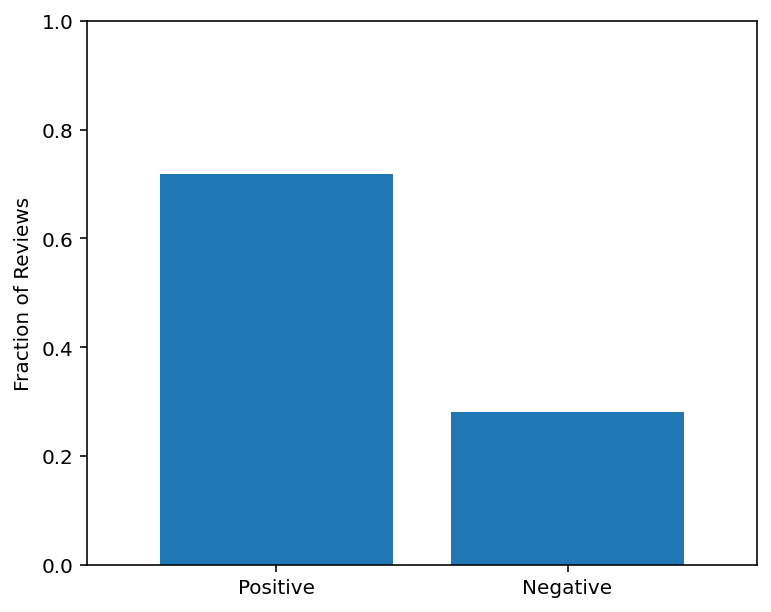

In [139]:
ax = provider_reviews['rating'].value_counts(normalize=True).plot.bar(width=0.8, rot=0, figsize=(6, 5))

ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of Reviews')
ax.set_xticklabels(['Positive', 'Negative']);

The data are imbalanced with approximately 70% of reviews being labeled as having positive sentiment, and the remaining 30% labeled as having negative sentiment. We can balance the data by selecting a sample of negative reviews previously rejected from the Healthgrades website for violating site policy. This will allow the model to get a sense for the contents of these reviews as well.

### Read in the rejected_reviews

In [6]:
rejected_reviews = pd.read_csv('./data/rejected_reviews.csv', encoding='ISO-8859-1')

In [7]:
rejected_reviews = rejected_reviews[(rejected_reviews['RejectionReason'] == 'Violates Site Policy') & (rejected_reviews['SentimentScore'] <= -0.5)]

rejected_reviews = rejected_reviews[rejected_reviews['CommentText'] != ''].dropna(subset=['CommentText']).reset_index(drop=True)

rejected_reviews.rename(columns={'CommentText': 'review_text'}, inplace=True)

In [8]:
rejected_reviews['rating'] = 1

Lastly, we'll read in a small test set. The test set contains data that the model has never seen before. This will provide an unbiased estimate of model performace for comparison with Alchemy and Indico.

### Read in the test data

In [9]:
test_dataset = pd.read_csv('./data/hgdata.csv', encoding='ISO-8859-1')

In [10]:
test_dataset.rename(columns={'comment_text': 'review_text',
                             'AlchemyBinary': 'alchemy_rating',
                             'IndicoBinary': 'indico_rating',
                             'MturkBinarySent': 'mturk_rating'}, inplace=True)

The figures below show the Alchemy and Indico sentiment scores on the test dataset. We can see that Alchemy returns a wide distribution of values with many hovering in the "neutral" zone around probability 0. On the other hand, Indico is much more certain in its classifications with values near both 0 and 1.

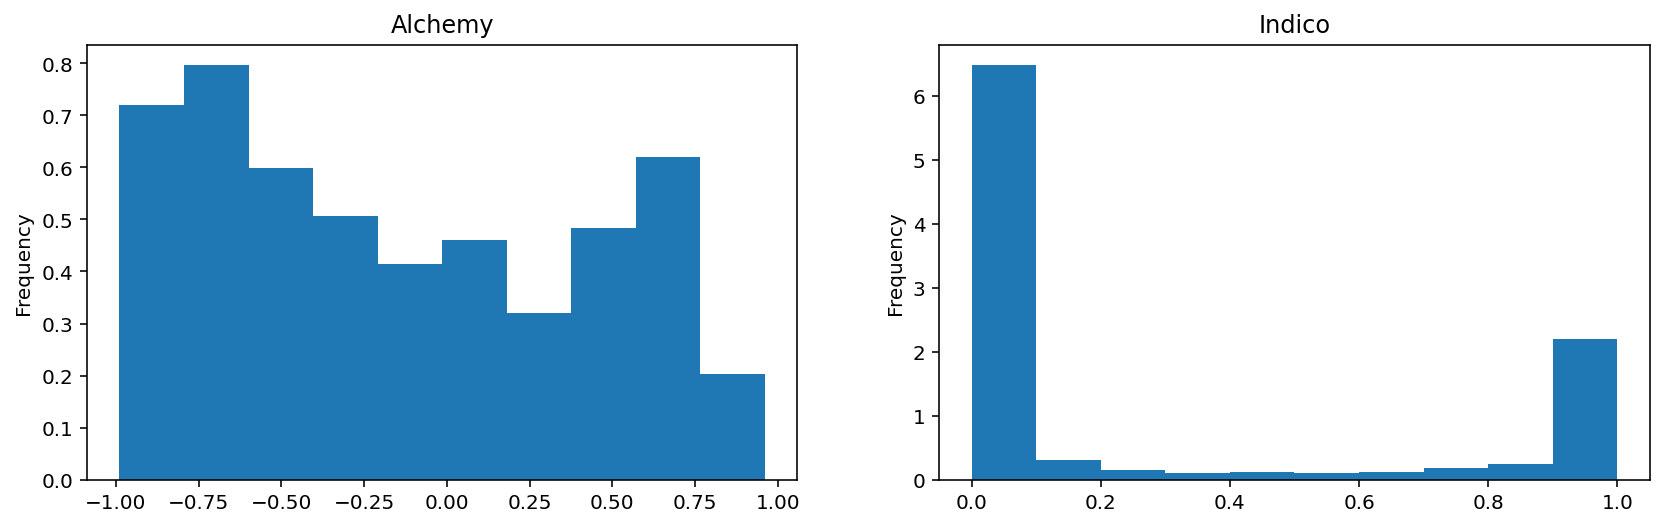

In [140]:
fig, ax = subplots(1, 2, figsize=(14, 4))

plot = (-1 * test_dataset['AlchemyScore']).plot.hist(density=True, title='Alchemy', ax=ax[0])
plot = (1 - test_dataset['IndicoScore']).plot.hist(density=True, title='Indico', ax=ax[1])

We'll combine the review datasets and create one final training dataset.

### Combine the provider reviews and rejected reviews for training

In [11]:
tmp = provider_reviews[['review_text', 'rating']].append(rejected_reviews[['review_text', 'rating']]).reset_index(drop=True)

In [12]:
negative = tmp[tmp['rating'] == 1]

positive = tmp[tmp['rating'] == 0].sample(n=negative.shape[0], random_state=0)

training_dataset = positive.append(negative).reset_index(drop=True)

Next, we'll process the reviews to remove punctuation and special characters, and then normalize the abbreviations.

### Clean the training and test data

In [13]:
training_dataset['review_text'] = training_dataset['review_text'].apply(lambda x: process_text(x)).apply(lambda x: replace_abbreviations(x))

In [14]:
test_dataset['review_text'] = test_dataset['review_text'].apply(lambda x: process_text(x)).apply(lambda x: replace_abbreviations(x))

The data are now split into training and validation sets.

### Split the data into training and validation sets

In [15]:
x_tr, x_va, y_tr, y_va = train_test_split(training_dataset['review_text'], training_dataset['rating'], test_size=0.2, random_state=0)

A logistic regression model performs well for this task. We can create a pipeline object which automatically vectorizes the text (using TF-IDF) and passes the results to the model. This will be done while at the same time looping over various vectorization parameters to find the combination that performs the best. We'll use 10-fold cross-validation here.

In [16]:
params = {'vec__ngram_range': [(1, 1), (1, 2), (2, 2)],
          'vec__stop_words': ['english', None],
          'vec__use_idf': [True, False],
          'vec__norm': ['l1', 'l2', None],
          'vec__sublinear_tf': [True, False],
          'vec__max_features': [5000, 10000, 15000, 30000]}

pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LogisticRegression(solver='liblinear'))
])

grid = GridSearchCV(pipeline, param_grid=params, scoring='balanced_accuracy', n_jobs=-1, cv=10, verbose=0)

grid.fit(x_tr, y_tr);

In [ ]:
print(grid.best_params_, grid.best_score_)

The best-performing model uses 15,000 unigram and bigram tokens with no stop-word removal. The TF-IDF values are then normalized using the L2-norm of the vector.

In [ ]:
model_tmp = grid.best_estimator_

In the parameter search above, we neglected looping over parameters for the vectorizer and logistic regression model together because the search space would have been very large. We will loop over values for the model regularization parameter $C$ below.

In [ ]:
params = {'clf__C': np.logspace(-1, 1, 20)}

grid = GridSearchCV(model_tmp, param_grid=params, scoring='balanced_accuracy', n_jobs=-1, cv=10, verbose=0)

grid.fit(x_tr, y_tr);

In [ ]:
print(grid.best_params_, grid.best_score_)

The cross-validation results suggest the final model should have an overall balanced accuracy of 94\%.

In [ ]:
model = grid.best_estimator_

### Save the model

In [17]:
dump(model, 'sentiment_model.joblib')

### Apply the model to the test data

Now that we have the model built we can apply it to our unseen test dataset. The results can then be compared to the Alchemy and Indico models.

In [18]:
test_dataset['predict'] = model.predict(test_dataset['review_text'])

test_dataset['probability'] = model.predict_proba(test_dataset['review_text'])[:, 1]

Text(0.5, 1.0, 'Healthgrades Model')

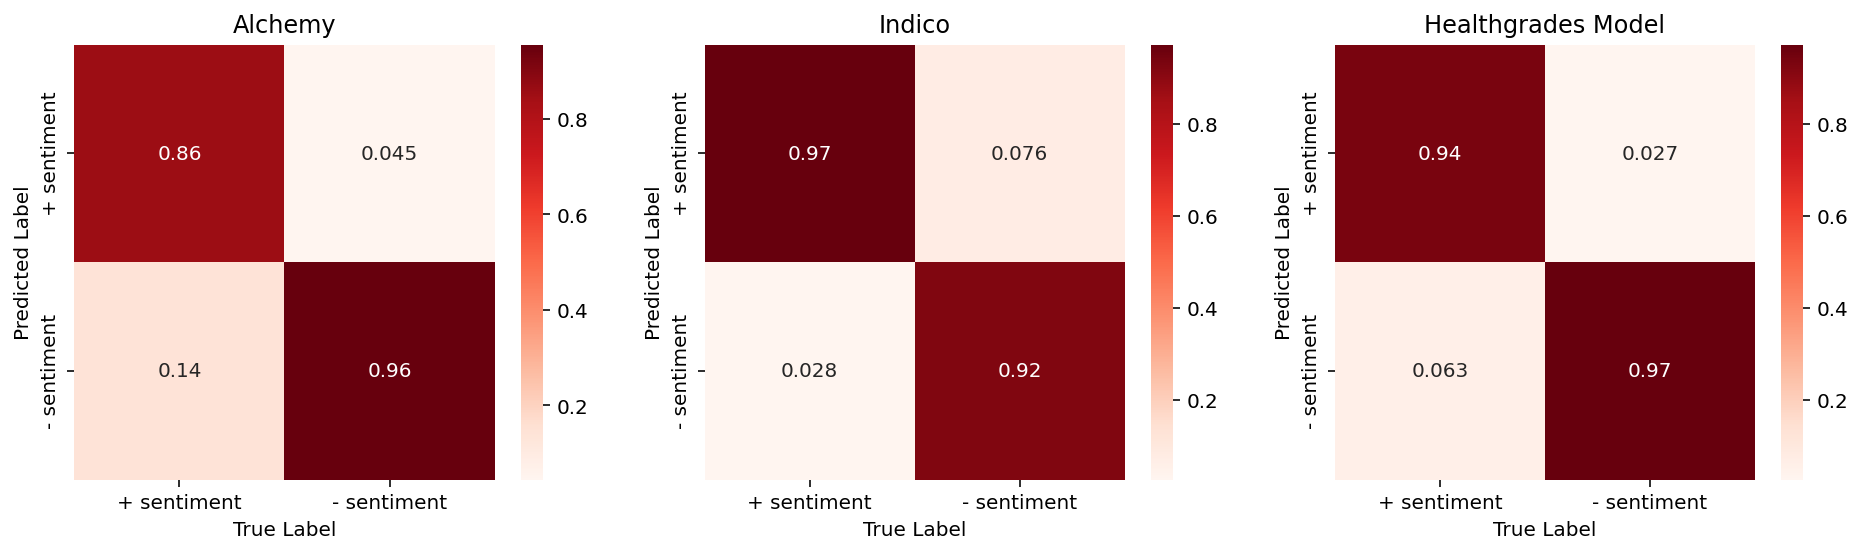

In [24]:
cm_alc = confusion_matrix(test_dataset['mturk_rating'], test_dataset['alchemy_rating']).T
cm_ind = confusion_matrix(test_dataset['mturk_rating'], test_dataset['indico_rating']).T
cm_mod = confusion_matrix(test_dataset['mturk_rating'], test_dataset['predict']).T

cm_alc = cm_alc.astype('float')/cm_alc.sum(axis=0)
cm_ind = cm_ind.astype('float')/cm_ind.sum(axis=0)
cm_mod = cm_mod.astype('float')/cm_mod.sum(axis=0)

fig, ax = subplots(nrows=1, ncols=3, figsize=(16,4))

classes = ['+ sentiment', '- sentiment']

tick_marks = np.arange(len(classes))

subplot(1, 3, 1)
sns.heatmap(cm_alc, annot=True, cmap='Reds')
xlabel('True Label')
ylabel('Predicted Label')
xticks(tick_marks + 0.5, classes)
yticks(tick_marks + 0.5, classes)
title('Alchemy')

subplot(1, 3, 2)
sns.heatmap(cm_ind, annot=True, cmap='Reds')
xlabel('True Label')
ylabel('Predicted Label')
xticks(tick_marks + 0.5, classes)
yticks(tick_marks + 0.5, classes)
title('Indico')

subplot(1, 3, 3)
sns.heatmap(cm_mod, annot=True, cmap='Reds')
xlabel('True Label')
ylabel('Predicted Label')
xticks(tick_marks + 0.5, classes)
yticks(tick_marks + 0.5, classes)
title('Healthgrades Model')

The $x$-axis represents the true label (positive or negative sentiment), while the $y$-axis represents the predicted label given by the Alchemy (left), Indico (middle), and Healthgrades (right) models. The Alchemy model accurately classifies positive-sentiment reviews 86% of the time, and misclassifies them 14% of the time. Similarly, it accurately classifies negative-sentiment reviews 96% of the time, and misclassifies them about 4% of the time. Alchemy has a relatively high false detection rate. In other words, it often thinks postive-sentiment reviews are actually negative in tone. This is problematic because large numbers of reviews are being passed on for manual analysis when they shouldn't be.

The Indico model accurately classifies positive-sentiment reviews 97% of the time and negative-sentiment reviews 92% of the time. This is actually quite good, but remember: Indico is also pricey! One of our goals is to get this level of performance using our own in-house model. Moving on, we find that the new Healthgrades model accurately classifies positive-sentiment reviews 94% of the time and negative-sentiment reviews 97% of the time. Not bad at all! The model is actually slightly better than expected compared to the accuracy value obtained earlier through cross-validation.

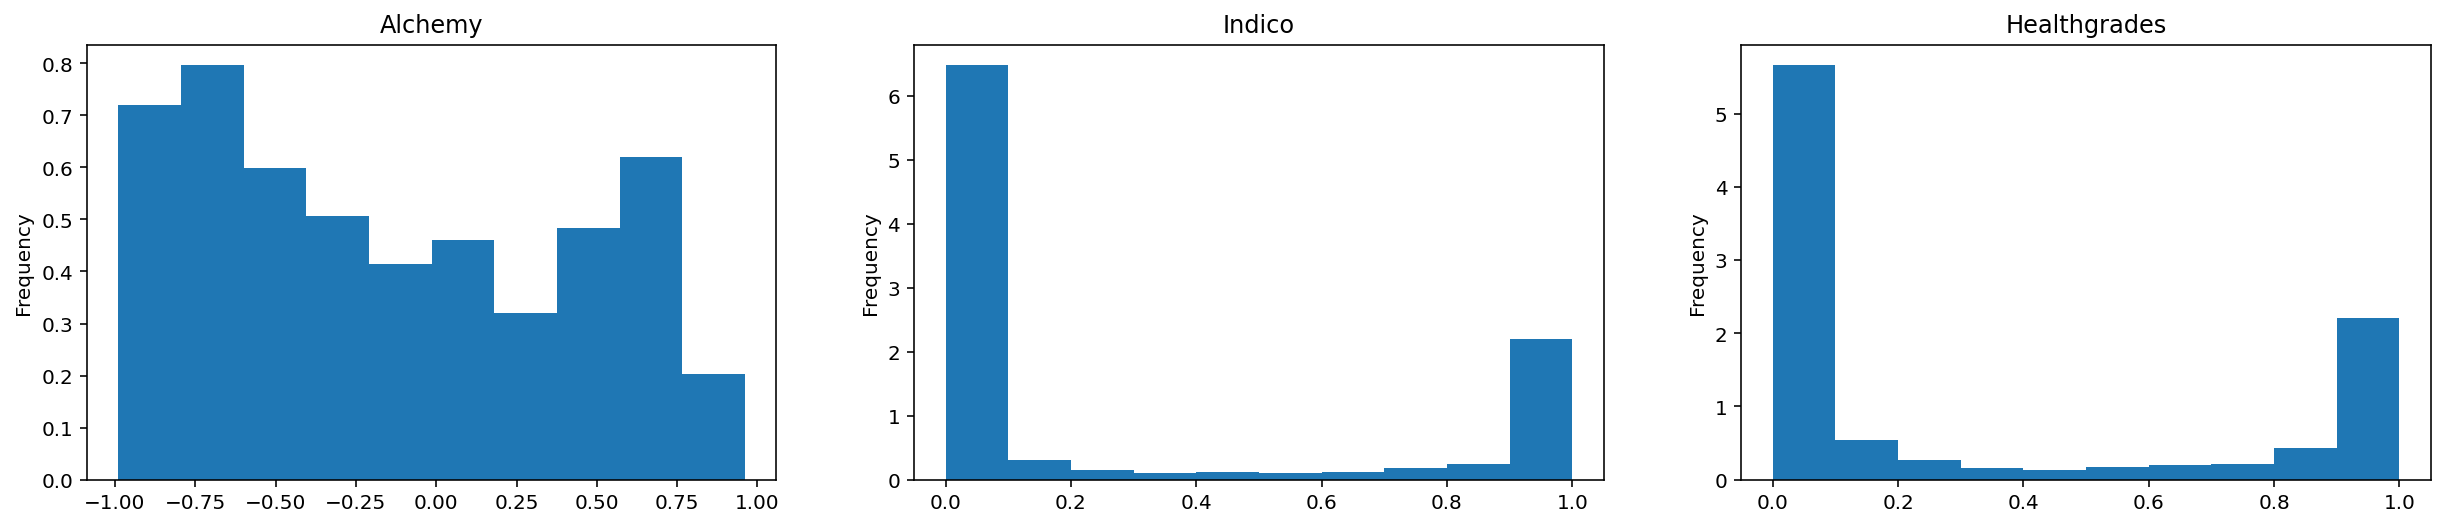

In [109]:
fig, ax = subplots(1, 3, figsize=(21, 4))

plot = (-1 * test_dataset['AlchemyScore']).plot.hist(density=True, title='Alchemy', ax=ax[0])
plot = (1 - test_dataset['IndicoScore']).plot.hist(density=True, title='Indico', ax=ax[1])
plot = test_dataset['probability'].plot.hist(density=True, title='Healthgrades', ax=ax[2])

Finally, we can compare the clasisfication probabilities of the three models on the test set. We can see that the sentiment polarity distribution of the Healthgrades model looks very similar to that of Indico.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>